# Compare Pore Volume

In [61]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle 
from tqdm import tqdm
import json
import yaml
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, std

from utils import isot_pore_volume, adsorption_units_conversion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:


with open('data/zeopp_asr_dicts.pickle', 'rb') as file: # Exported from dev-matscreen
    zeopp_asr_dicts = pickle.load(file)
    
zeopp_asr_dicts['FIQCEN']

{'He': {'ASA_A^2': 1116.95,
  'Density': 0.879097,
  'Input_sa': [1.2, 1.2, 100000],
  'NASA_A^2': 0.0,
  'POAV_A^3': 3191.51,
  'ASA_m^2/g': 2780.1,
  'PONAV_A^3': 0.0,
  'NASA_m^2/g': 0.0,
  'Input_volpo': [1.2, 1.2, 100000],
  'POAV_cm^3/g': 0.794372,
  'ASA_A^2_unit': 'A^2',
  'ASA_m^2/cm^3': 2443.98,
  'Density_unit': 'g/cm^3',
  'PONAV_cm^3/g': 0.0,
  'NASA_A^2_unit': 'A^2',
  'NASA_m^2/cm^3': 0.0,
  'POAV_A^3_unit': 'A^3',
  'ASA_m^2/g_unit': 'm^2/g',
  'PONAV_A^3_unit': 'A^3',
  'NASA_m^2/g_unit': 'm^2/g',
  'Unitcell_volume': 4570.21,
  'POAV_cm^3/g_unit': 'cm^3/g',
  'ASA_m^2/cm^3_unit': 'm^2/cm^3',
  'Number_of_pockets': 0,
  'PONAV_cm^3/g_unit': 'cm^3/g',
  'NASA_m^2/cm^3_unit': 'm^2/cm^3',
  'Number_of_channels': 1,
  'POAV_Volume_fraction': 0.69833,
  'Unitcell_volume_unit': 'A^3',
  'PONAV_Volume_fraction': 0.0,
  'Number_of_pockets_unit': None,
  'Number_of_channels_unit': None,
  'Pocket_surface_area_A^2': 0.0,
  'Channel_surface_area_A^2': 1116.95,
  'Input_structure_

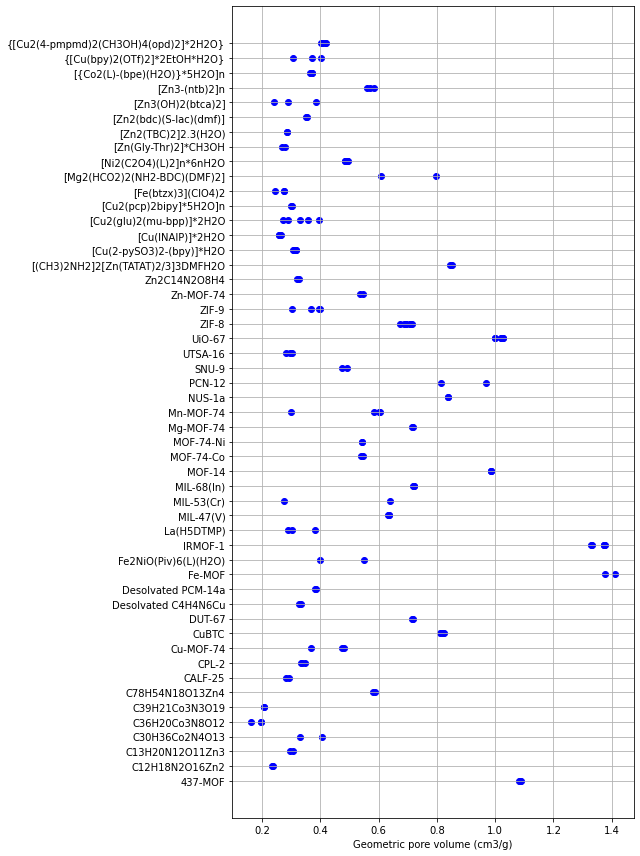

In [8]:
# Check structures that have duplicates and different pore volume

with open("data/step-10.yaml", "r") as file:
    mat_dict = yaml.safe_load(file)
    
plt.figure(figsize=[9,12])
labels = []
spreads = []
for mat_nist, mat_csd in mat_dict.items():
    if len(mat_csd)>1:
        x = [len(labels)]*len(mat_csd)
        pv = [ zeopp_asr_dicts[csd_refcode]['geometric']["AV_cm^3/g"] for csd_refcode in mat_csd.keys() ] 
        if any([z>1.5 for z in pv]):
            continue
        plt.scatter(pv,x,c='b')
        labels.append(mat_nist)
        spreads.append((max(pv)-min(pv))/max(pv))

plt.yticks(list(range(len(labels))), labels, rotation='horizontal')
plt.xlabel('Geometric pore volume (cm3/g)')
plt.grid()
plt.tight_layout()
plt.savefig("figures/si_compare_gpv.pdf")
plt.show()

In [11]:
# Check all characterization isotherms in database

count_n2, count_ar, count_n2_matched, count_ar_matched, = 0, 0, 0, 0

with open("data/step-10.yaml", "r") as file:
    matched_adsorbents =  list(yaml.safe_load(file).keys())
    
for isot in nistdb['Isotherms']:
    if isot['category'] != 'exp':
        continue
    if all([
        isot['adsorbates'][0]['name']=='Nitrogen',
        isot['temperature']==77,
    ]):
        count_n2+=1
        if isot['adsorbent']['name'] in matched_adsorbents:
            count_n2_matched+=1
    elif all([
        isot['adsorbates'][0]['name']=='Argon',
        isot['temperature']==87,
    ]):
        count_ar+=1
        if isot['adsorbent']['name'] in matched_adsorbents:
            count_ar_matched+=1
print(f"Total isotherms (all adsorbents) for N2@77K: {count_n2}, Ar@87K: {count_ar}")
print(f"Total isotherms (matched adsorbents) for N2@77K: {count_n2_matched}, Ar@87K: {count_ar_matched}")

Total isotherms (all adsorbents) for N2@77K: 4003, Ar@87K: 140
Total isotherms (matched adsorbents) for N2@77K: 871, Ar@87K: 25


In [12]:
# Check materials with at least one characterization isotherm
# NOTE: removing the `isot['category'] == 'exp'` condition will result in only ca. 25 more, but ambiguous... not worth!

PRINT_CHECK=False

with open("data/step-10.yaml", "r") as f1:
    mat_dict = yaml.safe_load(f1)
    
mat_w_isot, csd_w_isot = set({}), set({})
for mat_name in tqdm(mat_dict):
    at_least_one_isot = False
    for isot in nistdb['Isotherms']:
        if mat_name == isot['adsorbent']['name'] and isot['category'] == 'exp' and (
            (isot['adsorbates'][0]['name']=='Nitrogen' and isot['temperature']==77) or (
             isot['adsorbates'][0]['name']=='Argon'    and isot['temperature']==87)):
            at_least_one_isot=True
            mat_w_isot.add(mat_name)
            for csd_mat in mat_dict[mat_name]:
                csd_w_isot.add(csd_mat)
                
    # Printing only no-isothems
    if not PRINT_CHECK:
        continue
    if not at_least_one_isot:
        print(mat_name)
        for isot in nistdb['Isotherms']:
            if mat_name == isot['adsorbent']['name']:
                print(" - ", isot['category'], isot['adsorbates'][0]['name'], isot['temperature'])
                
print(f'Matched NIST-Adsorbents, with at least one char. iso.: {len(mat_w_isot)}')            

100%|█████████████████████████████████████████| 638/638 [00:13<00:00, 48.03it/s]

Matched NIST-Adsorbents, with at least one char. iso.: 316


In [29]:
# Compare CSD pore volumes (geometric, N2, and He) with the one computed from NIST-ISODB isotherms

PLOT_ISOTHERM = bool(0)
PRINT_OUTPUT = bool(0)
SHOW_MISSING = bool(0)

pore_vol_types = [
    'geometric',
    'N2',
    'He'
]

with open("data/step-10.yaml") as file:
    nist_csd_mats = yaml.safe_load(file)

for pvt in pore_vol_types:
    new_dict = { nist_name: {'structures': {}, 'isotherms': {}} for nist_name in nist_csd_mats}
    i = 0
    for nist_name, csd_refcodes in tqdm(nist_csd_mats.items()):
        i+=1
        zeopp_dicts = {}
        max_comp_porevol = 0
        for csd_refcode in csd_refcodes: 
            try:
                zeopp_dicts[csd_refcode] = zeopp_asr_dicts[csd_refcode][pvt]
                if pvt=='geometric':
                    comp_porevol = zeopp_dicts[csd_refcode]["AV_cm^3/g"] 
                else:
                    comp_porevol = zeopp_dicts[csd_refcode]["POAV_cm^3/g"]#+zeopp_dicts[csd_refcode]["PONAV_cm^3/g"] 
                new_dict[nist_name]['structures'][csd_refcode] = comp_porevol
            except:
                if SHOW_MISSING: print(f"Missing Zeopp data for {pvt} {csd_refcode}")
                continue
            if comp_porevol>max_comp_porevol:
                max_comp_porevol = comp_porevol
                max_comp_density = zeopp_dicts[csd_refcode]["Density"]

        if PRINT_OUTPUT:
            print(f">>>>>>>>>>>> {nist_name} {list(csd_refcodes.keys())} >>> Geom-porevols: ", *[round(x,2) for x in new_dict[nist_name]['structures'].values()])
        for isot in nistdb['Isotherms']:
            if isot['category'] != 'exp':
                continue
            if isot['adsorbent']['name']==nist_name:
                if all([
                    isot['adsorbates'][0]['name']=='Nitrogen',
                    isot['temperature']==77,
                ]) or all([
                    isot['adsorbates'][0]['name']=='Argon',
                    isot['temperature']==87,
                ]):
                    try:
                        pv = isot_pore_volume(isot, 
                                              plot=PLOT_ISOTHERM, 
                                              comp_porevol=max_comp_porevol,
                                              comp_density=max_comp_density,
                                            )
                        new_dict[nist_name]['isotherms'][isot['filename'].lower()] = pv # NOTE: I'm using lower cases for all isotherms ids
                        all 
                        if PRINT_OUTPUT:
                            print(f"Pore Volume from isotherm: {round(pv,2)} cm3/g ({isot['DOI']})")
                    except ValueError:
                        if PRINT_OUTPUT:
                            print("skipped")

        if not new_dict[nist_name]['structures'] or not new_dict[nist_name]['isotherms']:
            del new_dict[nist_name]

    with open(f'data/step-11-{pvt}.yml', 'w+') as yaml_file:
        print(f"# Pore volume (cm3/g) computed from the isotherms and from the structures ({pvt} method)", file=yaml_file)
        yaml.dump(new_dict, yaml_file)

100%|█████████████████████████████████████████| 638/638 [00:13<00:00, 48.61it/s]


In [30]:
# Deal with papers having multiple mpv (measured pore volume) for the same material: choose the policy

for pvt in pore_vol_types:
    print('Pore vol. type: ', pvt)
    with open(f"data/step-11-{pvt}.yml") as f:
        pv = yaml.safe_load(f)

    MAX_DEV_THR = 0.2
    POLICY = 2

    if POLICY==1:
        print(f"Removing all the papers where the max rel variation of the measure pore vol. is > {MAX_DEV_THR}")
    elif POLICY==2:
        print("Keep only the isotherm that leads to the larger mpv (max one mpv per paper)")
    print(f"Materials & isotherms before:", len(pv), sum([len(x['isotherms']) for x in pv.values()]))

    for nist_mat in list(pv.keys()):
        # Group the mpv by paper
        paper_mpv_dict = {}
        for isotherm_id, mpv in pv[nist_mat]['isotherms'].items():
            isotherm_id = isotherm_id.lower()
            paper_id = isotherm_id.split(".isotherm")[0]
            if paper_id not in paper_mpv_dict:
                paper_mpv_dict[paper_id] = []
            paper_mpv_dict[paper_id].append(mpv)

        # Check if they are consistent  
        if POLICY==1: # remove all if different
            paper_blacklist = []
            for paper, mpv_list in paper_mpv_dict.items():
                if len(mpv_list)==1: # no need for check
                    continue
                max_dev = (max(mpv_list) - min(mpv_list))/ max(mpv_list)
                if max_dev>MAX_DEV_THR:
                    paper_blacklist.append(paper)           

            # Delete isotherms from paper in blacklist
            for paper in paper_blacklist:
                for isotherm_id in list(pv[nist_mat]['isotherms'].keys()):
                    if isotherm_id.startswith(paper):
                        del pv[nist_mat]['isotherms'][isotherm_id]     

        elif POLICY==2: # remove all but the largest mpv
            for isotherm_id in list(pv[nist_mat]['isotherms'].keys()):
                paper_id = isotherm_id.split(".isotherm")[0]
                if not pv[nist_mat]['isotherms'][isotherm_id]==max(paper_mpv_dict[paper_id]):
                    del pv[nist_mat]['isotherms'][isotherm_id]     

        # If there is no isotherm left, delete the material from the list
        if len(pv[nist_mat]['isotherms'])==0:
            del pv[nist_mat]

    print(f"Materials & isotherms after:", len(pv), sum([len(x['isotherms']) for x in pv.values()]))

    with open(f'data/step-12-{pvt}.yml', 'w+') as yaml_file:
        print("# Pore volume (cm3/g) computed from the isotherms ('measured') and from the structures ('geometric)')", file=yaml_file)
        yaml.dump(pv, yaml_file)

Pore vol. type:  geometric
Keep only the isotherm that leads to the larger mpv (max one mpv per paper)
Materials & isotherms before: 314 889
Materials & isotherms after: 309 570
Pore vol. type:  N2
Keep only the isotherm that leads to the larger mpv (max one mpv per paper)
Materials & isotherms before: 299 871
Materials & isotherms after: 295 556
Pore vol. type:  He
Keep only the isotherm that leads to the larger mpv (max one mpv per paper)
Materials & isotherms before: 286 855
Materials & isotherms after: 282 543


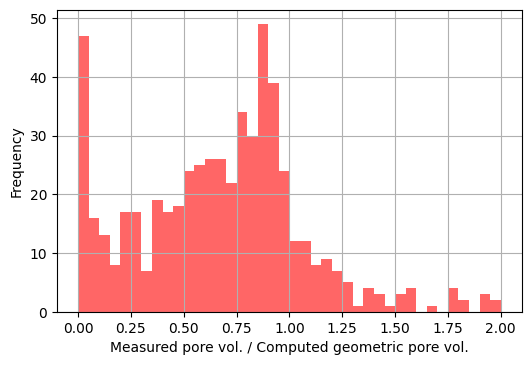

In [43]:
# Histogram of MPV/CPV (only geometric)
with open("data/step-12-geometric.yml") as f:
    pv = yaml.safe_load(f)
    
# check all the ratios
pore_vol_geom_ratio_list = []
for mat_name, mat_dict in pv.items():
#     if not mat_name=='ZIF-8':
#         continue
    max_geom_porevol = max(mat_dict['structures'].values())
    if max_geom_porevol==0:
        continue
    for meas_porevol in mat_dict['isotherms'].values():
        pore_vol_geom_ratio_list.append(meas_porevol/max_geom_porevol)
        #pore_vol_poav_ratio_list+=pap['pore_vol_poav_ratio']
        
plt.figure(figsize=[6,4], dpi=100)
plt.hist([ x for x in pore_vol_geom_ratio_list if x<2 ], bins=np.linspace(0,2,41), alpha=0.6, color='red', label = "Geom. pore vol.")
#plt.hist([ x for x in pore_vol_poav_ratio_list if x<2 ], bins=np.linspace(0,2,41), alpha=0.6, label = "POAV port vol.")
plt.xlabel("Measured pore vol. / Computed geometric pore vol.")
plt.ylabel("Frequency")
#plt.legend()
plt.grid()
plt.savefig("figures/histo_gpv.pdf")
plt.show()

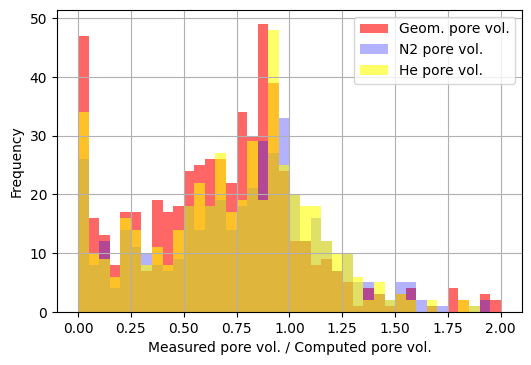

In [41]:
# Histogram of MPV/CPV (all CPV types overlapped)

plt.figure(figsize=[6,4], dpi=100)
pvts = ['geometric','N2','He']
colors = ['red', 'blue', 'yellow']
labels = ['Geom.', 'N2', 'He']
alphas = [0.6, 0.3, 0.6]

for i, pvt in enumerate(pvts):
    with open(f"data/step-12-{pvt}.yml") as f:
        pv = yaml.safe_load(f)

    pore_vol_geom_ratio_list = []
    for mat_name, mat_dict in pv.items():
        max_geom_porevol = max(mat_dict['structures'].values())
        if max_geom_porevol==0:
            continue
        for meas_porevol in mat_dict['isotherms'].values():
            pore_vol_geom_ratio_list.append(meas_porevol/max_geom_porevol)


    plt.hist([ x for x in pore_vol_geom_ratio_list if x<2 ], 
             bins=np.linspace(0,2,41), alpha=alphas[i], color=colors[i], label = f"{labels[i]} pore vol.")

plt.xlabel("Measured pore vol. / Computed pore vol.")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

plt.savefig("figures/si_histo_pvt.pdf")
plt.show()

In [44]:
rl = pore_vol_geom_ratio_list
print(f"Total isotherms: {len(rl)}")
print(f'Range 0-0.1:    {round(len([x for x in rl if x<0.1])/len(rl)*100,2)}%')
print(f'Range 0.1-0.75: {round(len([x for x in rl if 0.1<x<0.75])/len(rl)*100,2)}%')
print(f'Range 0.75-1.1: {round(len([x for x in rl if 0.75<x<1.1])/len(rl)*100,2)}%')
print(f'Range >1.1:     {round(len([x for x in rl if 1.1<x])/len(rl)*100,2)}%')

Total isotherms: 570
Range 0-0.1:    11.05%
Range 0.1-0.75: 41.93%
Range 0.75-1.1: 35.09%
Range >1.1:     11.93%


100%|██████████████████████████████████████| 309/309 [00:00<00:00, 17909.02it/s]
/tmp/ipykernel_8946/1189368207.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([ str(x) for x in range(1,ISOMAX) ] + [f"≥{ISOMAX}"] )


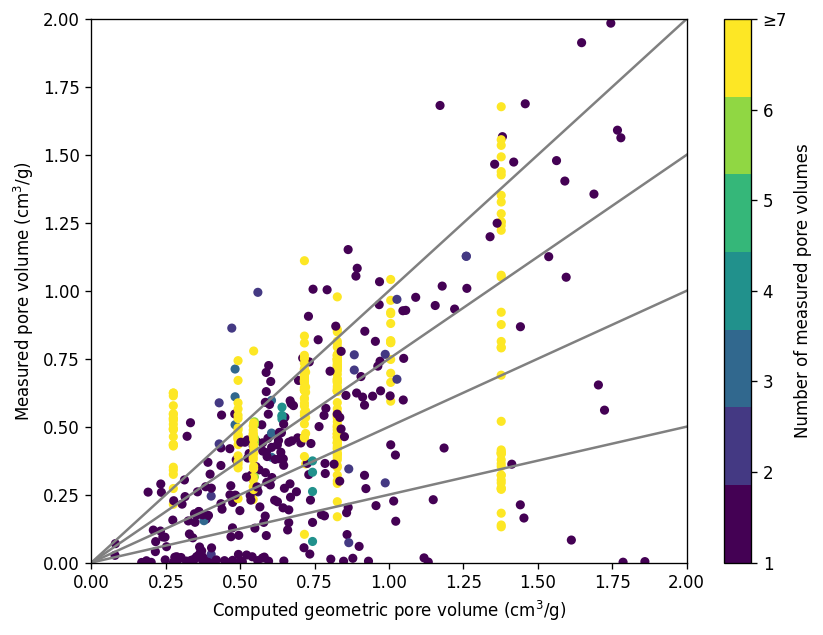

,Adsorbent,N. of Isotherms,Computed Pore Vol.,Measured Pore Vol.
0,MIL-53(Al),22,0.28,0.47 ± 0.11
1,UiO-66,19,0.49,0.48 ± 0.11
2,MOF-74-Ni,11,0.54,0.39 ± 0.09
3,Zn-MOF-74,9,0.55,0.44 ± 0.14
4,Mg-MOF-74,7,0.72,0.56 ± 0.11
5,ZIF-8,35,0.72,0.64 ± 0.15
6,CuBTC,78,0.83,0.58 ± 0.17
7,MIL-100(Fe),13,1.01,0.82 ± 0.12
8,IRMOF-1,40,1.38,0.78 ± 0.48


100%|██████████████████████████████████████| 295/295 [00:00<00:00, 16794.52it/s]
/tmp/ipykernel_8946/1189368207.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([ str(x) for x in range(1,ISOMAX) ] + [f"≥{ISOMAX}"] )


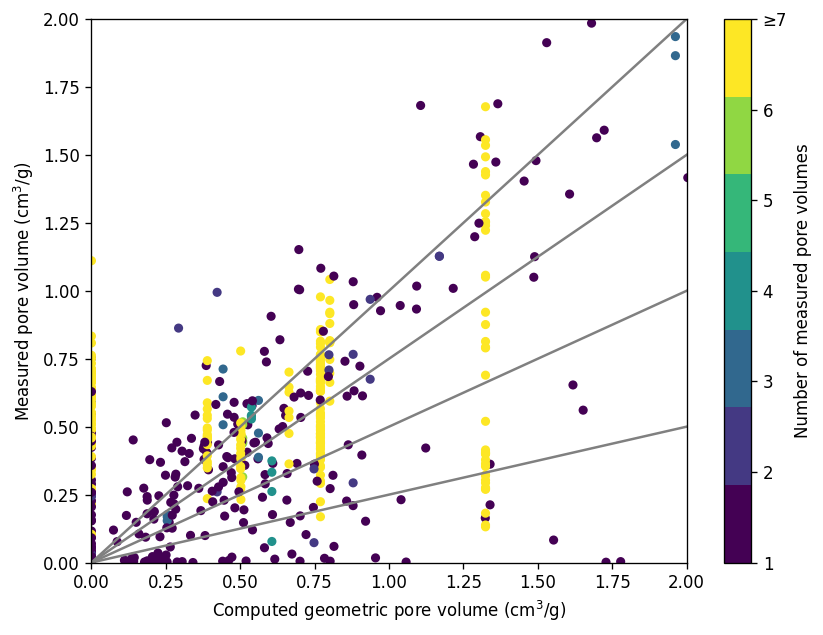

,Adsorbent,N. of Isotherms,Computed Pore Vol.,Measured Pore Vol.
0,MIL-53(Al),22,0.00,0.47 ± 0.11
1,ZIF-8,35,0.00,0.64 ± 0.15
2,UiO-66,19,0.39,0.48 ± 0.11
3,MOF-74-Ni,11,0.50,0.39 ± 0.09
4,Zn-MOF-74,9,0.50,0.44 ± 0.14
5,Mg-MOF-74,7,0.66,0.56 ± 0.11
6,CuBTC,78,0.77,0.58 ± 0.17
7,MIL-100(Fe),13,0.80,0.82 ± 0.12
8,IRMOF-1,40,1.32,0.78 ± 0.48


100%|██████████████████████████████████████| 282/282 [00:00<00:00, 16728.57it/s]
/tmp/ipykernel_8946/1189368207.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([ str(x) for x in range(1,ISOMAX) ] + [f"≥{ISOMAX}"] )


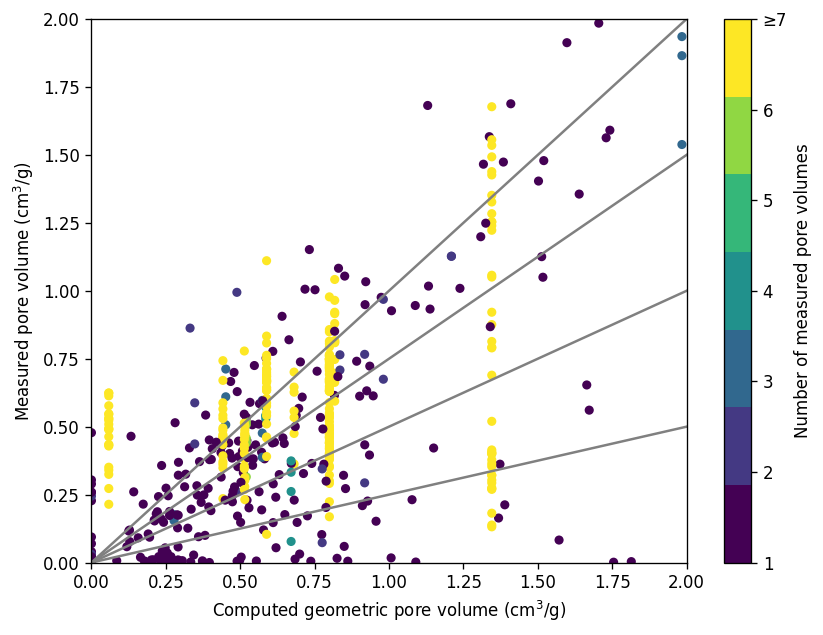

,Adsorbent,N. of Isotherms,Computed Pore Vol.,Measured Pore Vol.
0,MIL-53(Al),22,0.06,0.47 ± 0.11
1,UiO-66,19,0.44,0.48 ± 0.11
2,Zn-MOF-74,9,0.51,0.44 ± 0.14
3,MOF-74-Ni,11,0.52,0.39 ± 0.09
4,ZIF-8,35,0.59,0.64 ± 0.15
5,Mg-MOF-74,7,0.68,0.56 ± 0.11
6,CuBTC,78,0.80,0.58 ± 0.17
7,MIL-100(Fe),13,0.82,0.82 ± 0.12
8,IRMOF-1,40,1.35,0.78 ± 0.48


In [55]:
# Scatter plot with all measured isotherms counting as single dot
for pvt in pore_vol_types:
    with open(f"data/step-12-{pvt}.yml") as f:
        pv = yaml.safe_load(f)

    XMAX=2
    ISOMAX=7

    f = plt.figure(dpi=120, figsize=[8,6])
    cmap = plt.get_cmap('viridis',ISOMAX) # discrete
    x, y, c = [], [], []
    df = pd.DataFrame(columns=['Adsorbent', 'N. of Isotherms', 'Computed Pore Vol.', 'Measured Pore Vol.'])
    for nist_mat, d in tqdm(pv.items()):
        cpvs = [ x for x in d['structures'].values() if x<5] # computed pore volumes (list) DATA-CLEANING
        mpvs = [ x for x in d['isotherms'].values() if x<5] # computed pore volumes (list) DATA-CLEANING
        for mpv in mpvs:
            x.append(max(cpvs))
            y.append(mpv)
            c.append(min(len(mpvs),ISOMAX))
        if len(mpvs)>=ISOMAX:
            df = df.append(
                {'Adsorbent': nist_mat, 
                 #'N. of structures': str(len(cpvs)), 
                 'N. of Isotherms': str(len(mpvs)),
                 'Computed Pore Vol.': round(max(cpvs),2),
                 'Measured Pore Vol.': f"{round(mean(mpvs),2)} ± {round(std(mpvs),2)}",
                }, ignore_index=True)

    plt.scatter(x, y, c=c, s=20, cmap=cmap)

    # for mpv in d['isotherms'].values(): # measured pore volume
    #         plt.errorbar(x=cpv_mean, xerr=cpv_stdev, y=mpv, c='b')


    plt.xlabel('Computed geometric pore volume (cm$^3$/g)')
    plt.ylabel('Measured pore volume (cm$^3$/g)')
    for ratio in [1, 0.75, 0.5, 0.25]: # I wanted to include also 1.25 and make -- lines, but it becomes too messy!
        ls="-"
        plt.plot([0,XMAX],[0,XMAX*ratio], ls, c='grey', )
    plt.xlim([0,XMAX])
    plt.ylim([0,XMAX])
    cbar = plt.colorbar(label="Number of measured pore volumes")
    cbar.ax.set_yticklabels([ str(x) for x in range(1,ISOMAX) ] + [f"≥{ISOMAX}"] )
    plt.savefig(f"figures/geompv_mpv_{pvt}.pdf")
    plt.show()

    df = df.sort_values(by=['Computed Pore Vol.'])
    df = df.reset_index(drop=True)
    display(df)

In [57]:
# Prints Latex tables for the manuscript: here on screen the table that goes in the main paper and in figures/tabs_si.tex the tables to \input in the SI

caption1 = "MOFs with 7 or more characterization isotherms available. The values listed in the table are the maximum computed pore volume, if more than one structure is available, and the average measured pore volume with standard deviation, as assessed from the nitrogen and argon isotherms."

df_csd = pd.read_csv("data/step-00.csv")
csd_doi_dict = dict(zip(df_csd.identifier,df_csd.publication_doi))
print(df.to_latex(index=False, label='tab:most_measured', column_format='lccc', caption=caption1))

with open("figures/tabs_si.tex", "w") as f:
    for nist_mat in df.Adsorbent:
        df1 = pd.DataFrame()
        df1['Isotherm'] = pv[nist_mat]['isotherms'].keys()
        df1['Measured Pore Volume (cm^3/g)'] = pv[nist_mat]['isotherms'].values()
        print(df1.to_latex(
            index=False,
            longtable=True,
            label=f'tab:{nist_mat}_mpv',
            caption=f"{nist_mat}: NIST-ISODB label of the characterization isotherms and measured pore volume."
        ), file=f)
        df2 = pd.DataFrame()
        df2['CSD structure'] = pv[nist_mat]['structures'].keys()
        df2['DOI'] = [ csd_doi_dict[identifier] for identifier in pv[nist_mat]['structures'].keys() ]
        df2['Computed Pore Volume (cm^3/g)'] = pv[nist_mat]['structures'].values() 
        print(df2.to_latex(
            index=False,
            longtable=False,
            label=f'tab:{nist_mat}_cpv',
            caption=f"{nist_mat}: CSD refcode of the matched structures and computed geometric pore volume after computational desolvated."
        ), file=f)

\begin{table}
\centering
\caption{MOFs with 7 or more characterization isotherms available. The values listed in the table are the maximum computed pore volume, if more than one structure is available, and the average measured pore volume with standard deviation, as assessed from the nitrogen and argon isotherms.}
\label{tab:most_measured}
\begin{tabular}{lccc}
\toprule
  Adsorbent & N. of Isotherms &  Computed Pore Vol. & Measured Pore Vol. \\
\midrule
 MIL-53(Al) &              22 &                0.06 &        0.47 ± 0.11 \\
     UiO-66 &              19 &                0.44 &        0.48 ± 0.11 \\
  Zn-MOF-74 &               9 &                0.51 &        0.44 ± 0.14 \\
  MOF-74-Ni &              11 &                0.52 &        0.39 ± 0.09 \\
      ZIF-8 &              35 &                0.59 &        0.64 ± 0.15 \\
  Mg-MOF-74 &               7 &                0.68 &        0.56 ± 0.11 \\
      CuBTC &              78 &                0.80 &        0.58 ± 0.17 \\
MIL-100(Fe

100%|█████████████████████████████████████| 309/309 [00:00<00:00, 320563.92it/s]


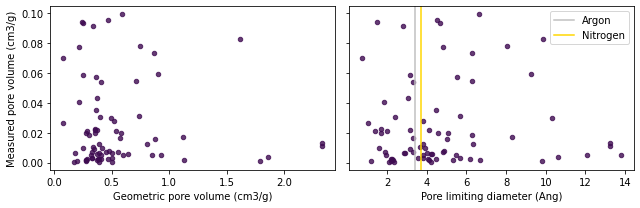

Number of points included: 76


In [67]:
# Statistics of materials with ner-zero measured pore vol
with open("data/step-12-geometric.yml") as f:
    pv = yaml.safe_load(f)
    
MPVMAX = 0.1
lmax=2
isosmax=10
    

x0, x1, y, c = [], [], [], []
for nist_mat, d in tqdm(pv.items()):
    cpvs = list(d['structures'].values()) # computed pore volumes (list)
    max_cpvs = max(cpvs)
    for k, v in d['structures'].items():
        if v==max_cpvs:
            max_cpvs_refcode = k
        lfs = zeopp_asr_dicts[max_cpvs_refcode]['geometric']['Largest_free_sphere']
    mpvs = list(d['isotherms'].values()) # computed pore volumes (list)
    for mpv in mpvs:
        if mpv<MPVMAX:
            x0.append(max_cpvs)
            x1.append(lfs)
            y.append(mpv)
            c.append(min(len(mpvs),isosmax))
            
            
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].scatter(x0, y, s=20, c='#3e0b51', alpha=0.8) # Color is viridis@0
axs[1].scatter(x1, y, s=20, c='#3e0b51', alpha=0.8)
axs[1].axvline(3.4, c='silver', label='Argon')
axs[1].axvline(1.86*2, c='gold', label='Nitrogen')
axs[1].legend()        
# for mpv in d['isotherms'].values(): # measured pore volume
#         plt.errorbar(x=cpv_mean, xerr=cpv_stdev, y=mpv, c='b')

axs[0].set_ylabel('Measured pore volume (cm3/g)')
axs[0].set_xlabel('Geometric pore volume (cm3/g)')
axs[1].set_xlabel('Pore limiting diameter (Ang)')
#plt.xlim([0,2.5])
#plt.ylim([0,0.1])
fig.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.savefig("figures/low_mpv.pdf")
plt.show()
print("Number of points included:", len(y))

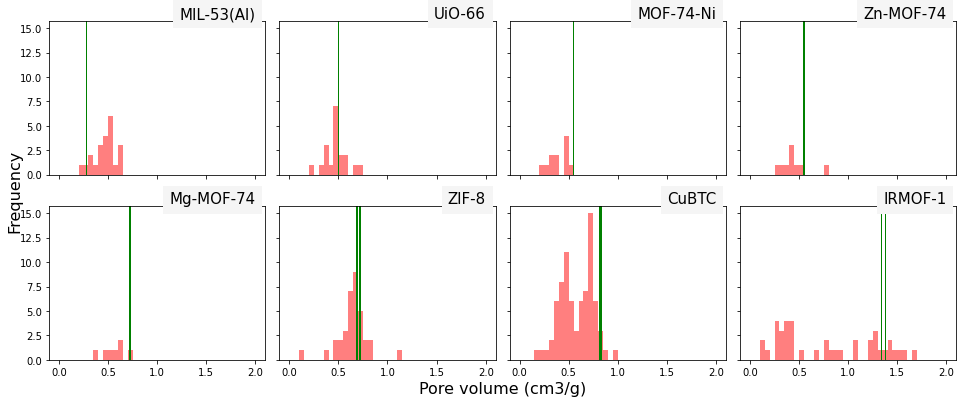

In [59]:
with open("data/step-12-geometric.yml") as f:
    pv = yaml.safe_load(f)
    
mat_selection = [
    'MIL-53(Al)',
    'UiO-66',
    'MOF-74-Ni',
    'Zn-MOF-74',
    'Mg-MOF-74',
    'ZIF-8',
    'CuBTC',
    'IRMOF-1',
]
    
fig, axs = plt.subplots(2,4,sharex=True,sharey=True, figsize=[14,6])
for i, mat_sel in enumerate(mat_selection):
    mat_dict = pv[mat_sel]
    axs.flat[i].hist(list(mat_dict['isotherms'].values()), bins=np.linspace(0,2,41), alpha=0.5, color ='red')
    #axs.flat[i].legend()
    axs.flat[i].text(x=2,y=16,s=mat_sel, horizontalalignment='right', backgroundcolor='whitesmoke', fontsize=15 )
    for gpv in mat_dict['structures'].values():
        axs.flat[i].axvline(x=gpv, c='green', lw=1)
        
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# Add a new subplot for common axis labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Pore volume (cm3/g)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.tight_layout()
plt.savefig("figures/histo_mat.pdf")
plt.show()

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.60it/s]


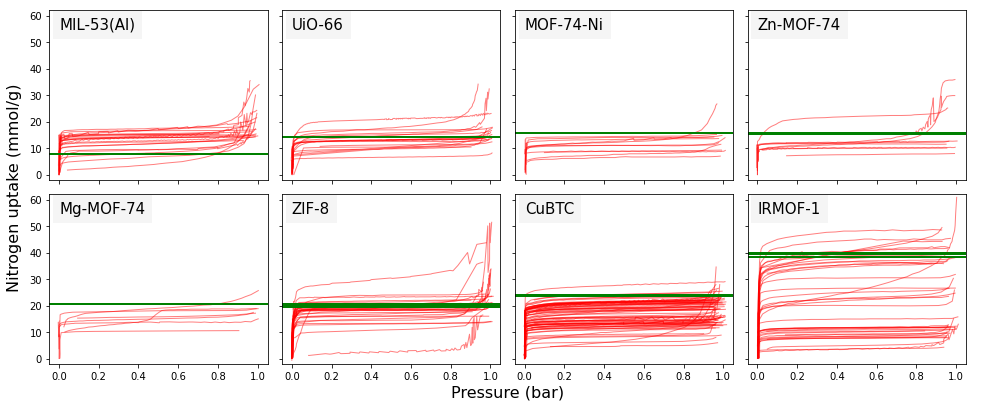

In [64]:
# Print isotherms for these materials
with open("data/step-12-geometric.yml") as f:
    pv = yaml.safe_load(f)
    
fig, axs = plt.subplots(2,4,sharex=True,sharey=True, figsize=[14,6])
dfl = [] 
for i, mat_sel in enumerate(tqdm(mat_selection)):
    mat_dict = pv[mat_sel]
    nisotherms = 0
    for iso_label, iso_pv in mat_dict['isotherms'].items():
        for isot in nistdb['Isotherms']:
            if isot['filename'].lower()==iso_label:
                # Search for the paper
                for bib in nistdb['Bibliography']:
                    if isot['DOI'].lower()==bib['DOI'].lower():
                        break
                else:
                    raise Exception(f'DOI {isot["DOI"]} not found') #this should never happen
                if isot['adsorbates'][0]['name']=='Nitrogen':  # Use only N2 or the plot won't be consistent
                    conv = adsorption_units_conversion(isot['adsorptionUnits'], isot['adsorbates'][0]['name'])
                    x = [isot_data['pressure'] for isot_data in isot['isotherm_data']]
                    y = [conv*isot_data['species_data'][0]['adsorption'] for isot_data in isot['isotherm_data']]
                    axs.flat[i].plot(x, y, c='red', lw=1, alpha=0.5)  
                    nisotherms+=1
                else: # Argon
                    conv = None
                break
        dfl.append({
            'MOF': mat_sel,
            'Isotherm': iso_label,
            'Adsorbate': isot['adsorbates'][0]['name'],
            'Temperature': isot['temperature'],
            'OriginalUnits':  isot['adsorptionUnits'],
            'Conv': round(conv,3) if not pd.isnull(conv) else None,
            'DOI': isot['DOI'],
            'Year': bib['year'],
            'PoreVolIsot': round(iso_pv,3),
        })
    txt_label = f"{mat_sel}"# - {nisotherms} isotherms"
    axs.flat[i].text(x=0,y=55,s=txt_label, horizontalalignment='left', backgroundcolor='whitesmoke', fontsize=15)
    for gpv in mat_dict['structures'].values():
        axs.flat[i].axhline(gpv*28.833, c='green', lw=2)    
        
df62 = pd.DataFrame(dfl)
df62 = df62.sort_values(by=['MOF', 'PoreVolIsot'])
df62.to_csv('data/step-13.csv', index=False)
    
fig.subplots_adjust(wspace=0.05, hspace=0.05)
axs.flat[i].set_ylim(-2,62)
axs.flat[i].set_xlim(-0.05,1.05)
# Add a new subplot for common axis labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Pressure (bar)", fontsize=16)
plt.ylabel("Nitrogen uptake (mmol/g)", fontsize=16)
plt.tight_layout()
plt.savefig("figures/isot_mat.pdf")
plt.show()

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 201.05it/s]


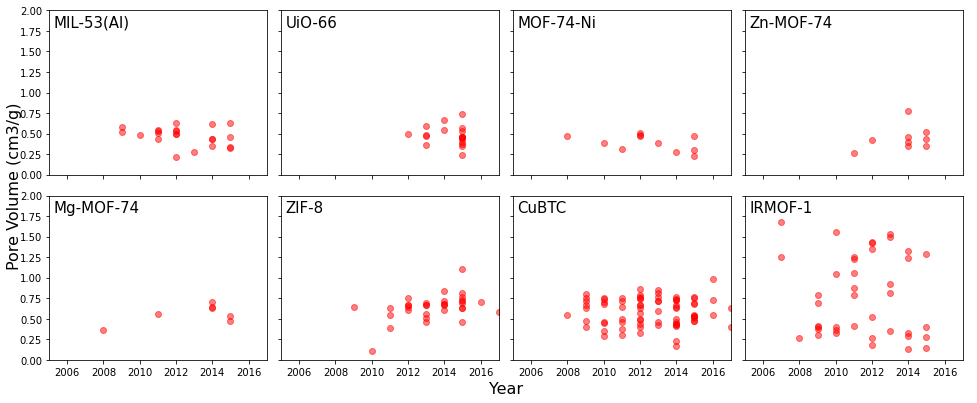

In [65]:
# Plot evolution of pore volume by year of synthesis

fig, axs = plt.subplots(2,4,sharex=True,sharey=True, figsize=[14,6])
df62 = pd.read_csv('data/step-13.csv')

mat_selection = [
    'MIL-53(Al)',
    'UiO-66',
    'MOF-74-Ni',
    'Zn-MOF-74',
    'Mg-MOF-74',
    'ZIF-8',
    'CuBTC',
    'IRMOF-1',
]

for i, mat_sel in enumerate(tqdm(mat_selection)):
    ax = axs.flat[i]
    x = df62[df62['MOF']==mat_sel].dropna()['Year']
    y = df62[df62['MOF']==mat_sel].dropna()['PoreVolIsot']
    ax.scatter(x, y, c='red', lw=1, alpha=0.5)  
    txt_label = f"{mat_sel}"# - {nisotherms} isotherms"
    ax.text(x=0.02,y=0.9,s=txt_label, horizontalalignment='left', fontsize=15, transform=ax.transAxes)
    ax.set_ylim(0,2)
    ax.set_xlim(df62.Year.min(), df62.Year.max())
    
fig.subplots_adjust(wspace=0.05, hspace=0.05)
# Add a new subplot for common axis labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Pore Volume (cm3/g)", fontsize=16)
plt.tight_layout()
plt.savefig("figures/porevol_year.pdf")
plt.show()